In [1]:
import numpy as np
import matplotlib.pyplot as plt
from py_pol.mueller import Mueller, degrees
from py_pol.stokes import Stokes
from pyswarms.single.global_best import GlobalBestPSO
from scipy.optimize import least_squares

In [3]:
# Cargar datos
%cd D:\Documentos\Medidas experimentales\Polarimetro\Pol_Cal_22_02_15_Sin_Lente
data = np.load("Step_4a_2022-02-15.npz")
Iexp_A = data["Iexp"]
Angles_1_A = data["angles_1"]
Angles_2_A = data["angles_2"]
data = np.load("Step_4b_2022-02-15.npz")
Iexp_B = data["Iexp"]
Angles_1_B = data["angles_1"]
Angles_2_B = data["angles_2"]

D:\Documentos\Medidas experimentales\Polarimetro\Pol_Cal_22_02_15_Sin_Lente


In [4]:
# Constantes
P1_p1 = 0.976
P1_p2 = 0.076
P1_az = 81.7 * degrees
P2_p1 = 0.975
P2_p2 = 0.014
P2_az = 172.7 * degrees
S_az = 72.1 * degrees
S_el = 42.1 * degrees

In [9]:
def modelB(par):
    S = Stokes().circular_light(intensity=par[0])
    # Mp1 = Mueller().diattenuator_perfect(azimuth=-P1_az+par[2])
    # Mr2 = Mueller().quarter_waveplate(azimuth=-par[1])
    Mr2 = Mueller().retarder_linear(azimuth=-par[1], R=par[4])
    Mp2 = Mueller().diattenuator_perfect(azimuth=-P2_az+par[2])
    Mp1 = Mueller().diattenuator_retarder_linear(
        p1=P1_p1,
        p2=P1_p2,
        R=par[3],
        azimuth=-P1_az)
    # S = Stokes().general_azimuth_ellipticity(intensity=2.4142, azimuth=S_az, ellipticity=S_el)
    # Mrc = Mueller().diattenuator_retarder_linear(azimuth=45*degrees+par[4], R=par[2], p1=par[5], p2=par[6])
    Mr2_rot = Mr2.rotate(angle=Angles_1_B, keep=True)
    Mp2_rot= Mp2.rotate(angle=Angles_2_B, keep=True)
    
    Sf = Mp2_rot * Mr2_rot * Mp1 * S
    Ib = Sf.parameters.intensity()
    
    return Ib

def errorB(par):
    Ib = modelB(par)
    Eb = (Ib - Iexp_B).flatten()
    return Eb / np.sqrt(Ib.size)

def modelA(par):
    S = Stokes().circular_light(intensity=par[0])
    # Mp1 = Mueller().diattenuator_perfect(azimuth=-P1_az+par[2])
    # Mr2 = Mueller().quarter_waveplate(azimuth=-par[1])
    Mr2 = Mueller().retarder_linear(azimuth=-par[1], R=par[4])
    Mp2 = Mueller().diattenuator_perfect(azimuth=-P2_az+par[2])
    Mp1 = Mueller().diattenuator_retarder_linear(
        p1=P1_p1,
        p2=P1_p2,
        R=par[3],
        azimuth=-P1_az)
    # S = Stokes().general_azimuth_ellipticity(intensity=2.4142, azimuth=S_az, ellipticity=S_el)
    Mrc = Mueller().retarder_linear(azimuth=45*degrees+par[5], R=par[6])
    Mp1_rot = Mp1.rotate(angle=Angles_1_A, keep=True)
    Mr2_rot= Mr2.rotate(angle=Angles_2_A, keep=True)
    
    Sf = Mp2 * Mr2_rot * Mrc * Mp1_rot * S
    Ia = Sf.parameters.intensity()
    
    return Ia

def errorA(par):
    Ia = modelA(par)
    Ea = (Ia - Iexp_A).flatten()
    return Ea / np.sqrt(Ia.size)

def opt_func_PSO_ind(Transitions, fun, args):
    """Function needed as interface between PSO algorithm and error_global."""
    num_particles = Transitions.shape[0]  # number of particles
    error = [np.linalg.norm(fun(Transitions[i,:], *args)) for i in range(num_particles)]
    return error

def Ajustar(fun, title=""):
    # Ajuste
    bounds = ([1, 0, -3*degrees, 0, 80*degrees, -90*degrees, 80*degrees], 
              [3, 180*degrees, 3*degrees, 360*degrees, 100*degrees, 90*degrees, 100*degrees])
    options_individual = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    args = []

    optimizer = GlobalBestPSO(
                    n_particles=40, dimensions=len(bounds[0]), options=options_individual, bounds=bounds)
    cost, result = optimizer.optimize(opt_func_PSO_ind, iters=70, fun=fun, args=args)
    
    result2 = least_squares(fun, bounds=bounds, x0=result, ftol=1e-11, xtol=1e-11, gtol=1e-11)
    cost2 = np.linalg.norm(fun(result2.x))
    # cost2 = result2.cost
    result2 = result2.x
    
    # Representacion
    if title == "Solo A":
        I_model = modelA(result)
        I_exp = Iexp_A
    else:
        I_model = modelB(result)
        I_exp = Iexp_B        
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.imshow(I_model)
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(I_exp)
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(I_exp-I_model)
    plt.colorbar()
    plt.suptitle(title)
    
    if title == "Solo A":
        I_model = modelA(result2)
    else:
        I_model = modelB(result2)
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.imshow(I_model)
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(I_exp)
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(I_exp-I_model)
    plt.colorbar()
    plt.suptitle(title)
    
    # Print
    print(title, " PSO\n - Cost = {}\n - S0 = {}\n - R2 az = {} deg\n - P1 offset = {} deg\n - P1 R = {} deg\n - R2 R = {} deg\n - Rc offset = {} deg\n - Rc R = {} deg\n".format(
        cost, result[0], *(result[1:] / degrees)))
    print(title, " PSO + least_squares\n - Cost = {}\n - S0 = {}\n - R2 az = {} deg\n - P1 offset = {} deg\n - P1 R = {} deg\n - R2 R = {} deg\n - Rc offset = {} deg\n - Rc R = {} deg".format(
        cost2, result2[0], *(result2[1:] / degrees)))

2022-02-21 11:18:41,301 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|70/70, best_cost=0.0383
2022-02-21 11:19:12,072 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.03834499568355121, best pos: [2.41680106 2.84193382 0.02034538 1.19537488 1.50317    0.00625816
 1.57909798]


Solo B  PSO
 - Cost = 0.03834499568355121
 - S0 = 2.416801058079536
 - R2 az = 162.83081334941082 deg
 - P1 offset = 1.1657046708466356 deg
 - P1 R = 68.48993538393377 deg
 - R2 R = 86.12529671205087 deg
 - Rc offset = 0.35856610305756126 deg
 - Rc R = 90.4756495596353 deg

Solo B  PSO + least_squares
 - Cost = 0.015817483782822196
 - S0 = 2.3829142545671753
 - R2 az = 162.2956730770381 deg
 - P1 offset = 3.0 deg
 - P1 R = 88.41507315043054 deg
 - R2 R = 83.1625240062045 deg
 - Rc offset = 0.35856610305756126 deg
 - Rc R = 90.4756495596353 deg


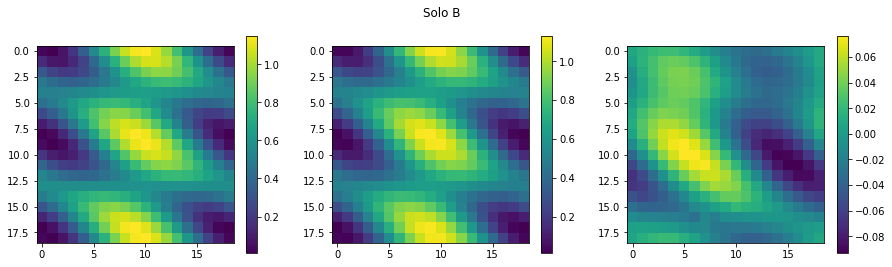

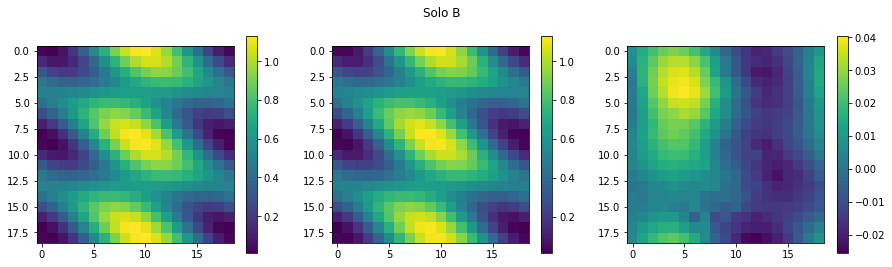

In [10]:
Ajustar(errorB, "Solo B")

2022-02-21 11:20:16,727 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|70/70, best_cost=0.0535
2022-02-21 11:20:53,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.05349372059006447, best pos: [ 2.36773732  2.88638303 -0.00574314  0.39864143  1.5303681  -0.1669846
  1.61966924]


Solo A  PSO
 - Cost = 0.05349372059006447
 - S0 = 2.367737319602061
 - R2 az = 165.3775654683461 deg
 - P1 offset = -0.3290576694910468 deg
 - P1 R = 22.840471363287705 deg
 - R2 R = 87.68363307147683 deg
 - Rc offset = -9.567512717677936 deg
 - Rc R = 92.800211480057 deg

Solo A  PSO + least_squares
 - Cost = 0.031692397346425136
 - S0 = 2.2599648369765912
 - R2 az = 162.75675477959211 deg
 - P1 offset = 3.0 deg
 - P1 R = 73.29642724645407 deg
 - R2 R = 80.00000000000001 deg
 - Rc offset = -6.682576876170651 deg
 - Rc R = 93.56487147295155 deg


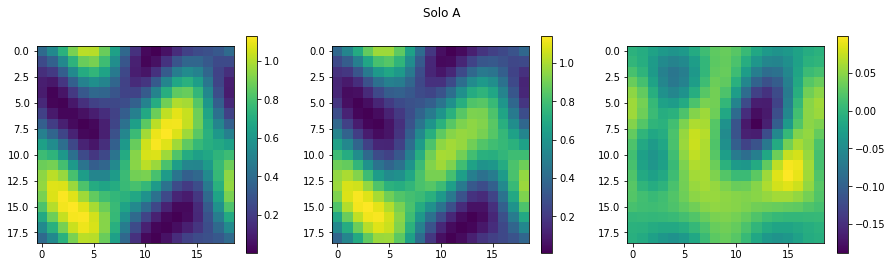

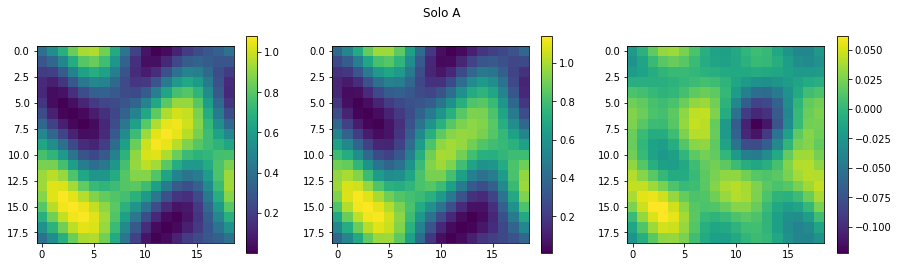

In [11]:
Ajustar(errorA, "Solo A")

In [32]:
def model2(par):
    S = Stokes().circular_light(intensity=par[0])
    # Mp1 = Mueller().diattenuator_perfect(azimuth=-P1_az+par[2])
    # Mr2 = Mueller().quarter_waveplate(azimuth=-par[1])
    Mr2 = Mueller().retarder_linear(azimuth=-par[1], R=par[4])
    Mp2 = Mueller().diattenuator_perfect(azimuth=-P2_az)
    Mp1 = Mueller().diattenuator_retarder_linear(
        p1=P1_p1,
        p2=P1_p2,
        R=par[3],
        azimuth=-P1_az+par[2])
    # S = Stokes().general_azimuth_ellipticity(intensity=2.4142, azimuth=S_az, ellipticity=S_el)
    Mrc = Mueller().retarder_linear(azimuth=45*degrees+par[5], R=par[6])
    
    Mp1_rot = Mp1.rotate(angle=Angles_1_A, keep=True)
    Mr2_rot= Mr2.rotate(angle=Angles_2_A, keep=True)    
    Sf = Mp2 * Mr2_rot * Mrc * Mp1_rot * S
    Ia = Sf.parameters.intensity()
    
    Mr2_rot = Mr2.rotate(angle=Angles_1_B, keep=True)
    Mp2_rot= Mp2.rotate(angle=Angles_2_B, keep=True)
    Sf = Mp2_rot * Mr2_rot * Mp1 * S
    Ib = Sf.parameters.intensity()
    
    return Ia, Ib

def error2(par):
    Ia, Ib = model2(par)
    Ea = (Ia - Iexp_A).flatten()
    Eb = (Ib - Iexp_B).flatten()
    return np.concatenate((Ea, Eb)) / (Ia.size + Ib.size)

def opt_func_PSO_ind(Transitions, fun, args):
    """Function needed as interface between PSO algorithm and error_global."""
    num_particles = Transitions.shape[0]  # number of particles
    error = [np.linalg.norm(fun(Transitions[i,:], *args)) for i in range(num_particles)]
    return error

def Ajustar2():
    # Ajuste
    fun=error2
    bounds = ([1, 0, -0.03*degrees, 0, 80*degrees, -45*degrees, 80*degrees], 
              [3, 180*degrees, 0.03*degrees, 360*degrees, 100*degrees, 45*degrees, 100*degrees])
    options_individual = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    args = []

    optimizer = GlobalBestPSO(
                    n_particles=50, dimensions=len(bounds[0]), options=options_individual, bounds=bounds)
    cost, result = optimizer.optimize(opt_func_PSO_ind, iters=80, fun=fun, args=args)
    
    result2 = least_squares(fun, bounds=bounds, x0=result, ftol=1e-11, xtol=1e-11, gtol=1e-11)
    cost2 = np.linalg.norm(fun(result2.x))
    # cost2 = result2.cost
    result2 = result2.x
    
    # Representacion
    title = "Ambas"
    I_modelA, I_modelB = model2(result)
    
    plt.figure(figsize=(15,8))
    plt.subplot(2,3,1)
    IDimage = plt.imshow(Iexp_A, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,2)
    IDimage = plt.imshow(I_modelA, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,3)
    IDimage = plt.imshow(Iexp_A-I_modelA, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,4)
    IDimage = plt.imshow(Iexp_B, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,5)
    IDimage = plt.imshow(I_modelB, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,6)
    IDimage = plt.imshow(Iexp_B-I_modelB, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.suptitle(title)
    
    I_modelA, I_modelB = model2(result2)
    plt.figure(figsize=(15,8))
    plt.subplot(2,3,1)
    IDimage = plt.imshow(Iexp_A, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,2)
    IDimage = plt.imshow(I_modelA, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,3)
    IDimage = plt.imshow(Iexp_A-I_modelA, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,4)
    IDimage = plt.imshow(Iexp_B, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,5)
    IDimage = plt.imshow(I_modelB, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.subplot(2,3,6)
    IDimage = plt.imshow(Iexp_B-I_modelB, origin='lower')
    IDimage.set_cmap("magma")
    plt.colorbar()
    plt.suptitle(title)
    
    # Print
    print(title, " PSO\n - Cost = {}\n - S0 = {}\n - R2 az = {} deg\n - P1 offset = {} deg\n - P1 R = {} deg\n - R2 R = {} deg\n - Rc offset = {} deg\n - Rc R = {} deg\n".format(
        cost, result[0], *(result[1:] / degrees)))
    print(title, " PSO + least_squares\n - Cost = {}\n - S0 = {}\n - R2 az = {} deg\n - P1 offset = {} deg\n - P1 R = {} deg\n - R2 R = {} deg\n - Rc offset = {} deg\n - Rc R = {} deg".format(
        cost2, result2[0], *(result2[1:] / degrees)))

2022-02-21 17:22:30,119 - pyswarms.single.global_best - INFO - Optimize for 80 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|80/80, best_cost=0.00158
2022-02-21 17:23:50,135 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0015820202938478082, best pos: [ 2.28870316e+00  2.90990529e+00 -2.76769831e-04  4.95206960e+00
  1.48473828e+00 -2.59639786e-01  1.62552565e+00]


Ambas  PSO
 - Cost = 0.0015820202938478082
 - S0 = 2.2887031629485253
 - R2 az = 166.72529167981676 deg
 - P1 offset = -0.015857743214101064 deg
 - P1 R = 283.73268809042304 deg
 - R2 R = 85.06923715253355 deg
 - Rc offset = -14.876263909229115 deg
 - Rc R = 93.13575897515253 deg

Ambas  PSO + least_squares
 - Cost = 0.0014713698358646092
 - S0 = 2.298896826338903
 - R2 az = 167.33083183832397 deg
 - P1 offset = 0.029999999999999992 deg
 - P1 R = 281.3963957394474 deg
 - R2 R = 83.20228361514206 deg
 - Rc offset = -13.687105503717973 deg
 - Rc R = 91.74130734563077 deg


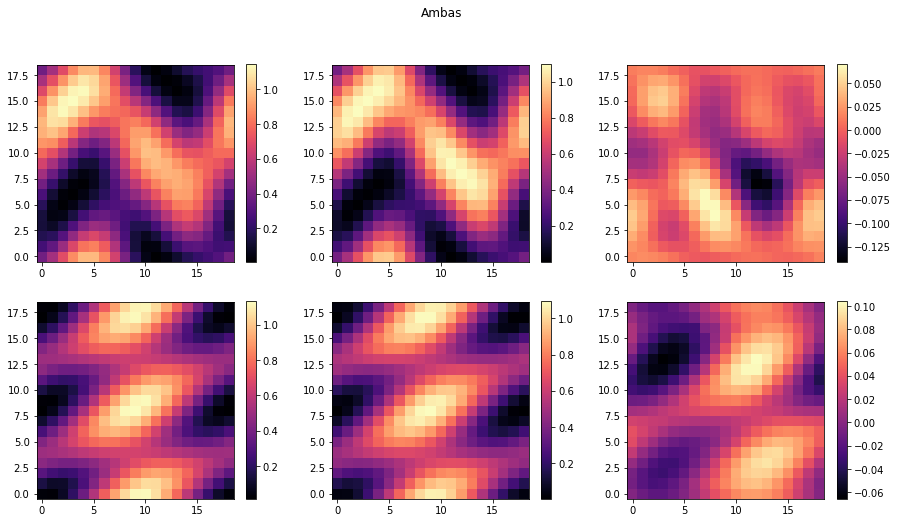

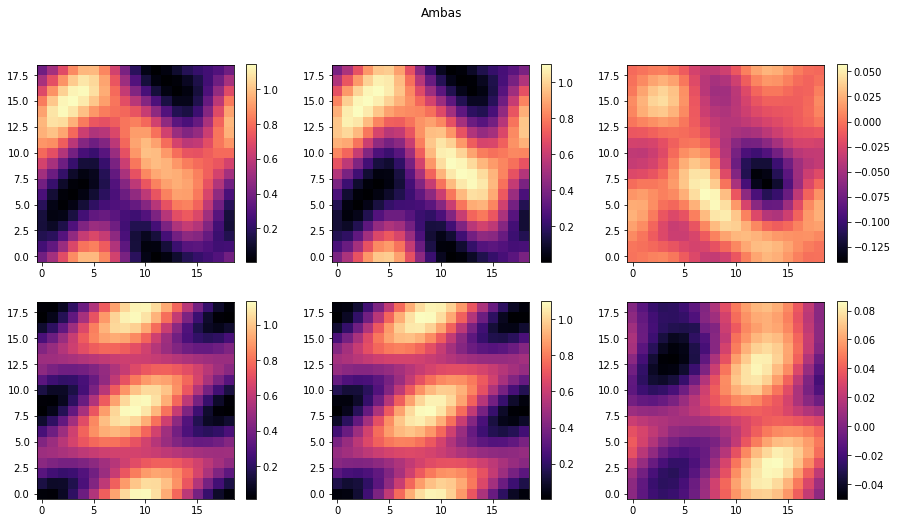

In [33]:
Ajustar2()

The intensity of M * M @ 45.00 deg * S is (a.u.):
The mean value is 0.4972375690607735 +- 0.354517949771394


d:\codigo\py_pol\py_pol\stokes.py:792: RuntimeWarning: invalid value encountered in true_divide
  degree_pol_prov = np.sqrt(


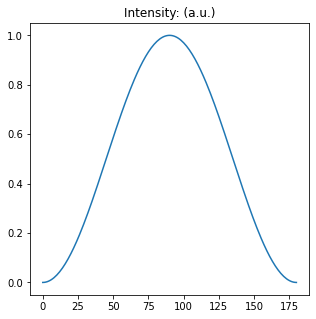


The intensity of M * M @ 45.00 deg * S is (a.u.):
The mean value is 0.5027624309392266 +- 0.354517949771394


d:\codigo\py_pol\py_pol\stokes.py:792: RuntimeWarning: invalid value encountered in true_divide
  degree_pol_prov = np.sqrt(


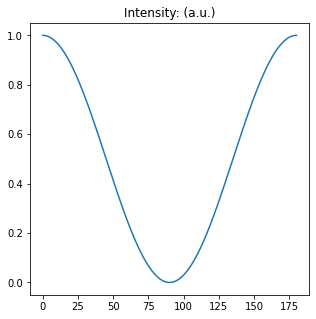

array([1.00000000e+00, 9.99695414e-01, 9.98782025e-01, 9.97260948e-01,
       9.95134034e-01, 9.92403877e-01, 9.89073800e-01, 9.85147863e-01,
       9.80630848e-01, 9.75528258e-01, 9.69846310e-01, 9.63591927e-01,
       9.56772729e-01, 9.49397023e-01, 9.41473796e-01, 9.33012702e-01,
       9.24024048e-01, 9.14518786e-01, 9.04508497e-01, 8.94005377e-01,
       8.83022222e-01, 8.71572413e-01, 8.59669900e-01, 8.47329185e-01,
       8.34565303e-01, 8.21393805e-01, 8.07830738e-01, 7.93892626e-01,
       7.79596452e-01, 7.64959632e-01, 7.50000000e-01, 7.34735781e-01,
       7.19185573e-01, 7.03368322e-01, 6.87303297e-01, 6.71010072e-01,
       6.54508497e-01, 6.37818678e-01, 6.20960948e-01, 6.03955845e-01,
       5.86824089e-01, 5.69586550e-01, 5.52264232e-01, 5.34878237e-01,
       5.17449748e-01, 5.00000000e-01, 4.82550252e-01, 4.65121763e-01,
       4.47735768e-01, 4.30413450e-01, 4.13175911e-01, 3.96044155e-01,
       3.79039052e-01, 3.62181322e-01, 3.45491503e-01, 3.28989928e-01,
      

In [58]:
angulos = np.linspace(0, 180*degrees, 181)
S1 = Stokes().circular_light('r')
S2 = Stokes().circular_light('l')
R1 = Mueller().quarter_waveplate(azimuth=45*degrees)
R2 = Mueller().quarter_waveplate(azimuth=135*degrees)
P = Mueller().diattenuator_perfect(azimuth=angulos)
Sfin = P * R1 * S1
Sfin.parameters.intensity(draw=True)
Sfin = P * R1 * S2
Sfin.parameters.intensity(draw=True)

Linear 60 150
Modified 84 174


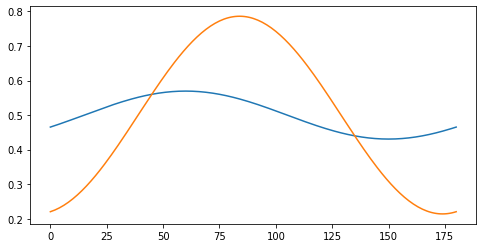

In [100]:
angulos = np.linspace(0, 180*degrees, 181)
S1 = Stokes().general_azimuth_ellipticity(azimuth=60*degrees, ellipticity=40*degrees, degree_pol=0.8)
P = Mueller().diattenuator_linear(azimuth=angulos, p1=1, p2=0.00)
Sfin = P * S1
I = Sfin.parameters.intensity()


P = Mueller().diattenuator_azimuth_ellipticity(azimuth=angulos, p1=1, p2=0.00, ellipticity=0*degrees)
R = Mueller().retarder_linear(azimuth=45*degrees, R=40*degrees)
Sfin = P * R * S1
I2 = Sfin.parameters.intensity()

plt.figure(figsize=(8,4))
plt.plot(angulos/degrees, I)
plt.plot(angulos/degrees, I2)

print("Linear", np.argmax(I), np.argmin(I))
print("Modified", np.argmax(I2), np.argmin(I2))